# **Algorithmic Trading: German Electricity Market**

In [1]:
%load_ext autoreload
%autoreload 2

import random

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import seaborn as sns

from pykalman import KalmanFilter
from statsmodels.graphics.tsaplots import plot_acf

from constants import PLOT_CONFIGS
from utility import plot_histograms

pd.options.mode.chained_assignment = None

random.seed(42)
np.random.seed(42)

In [3]:
df = pd.read_csv("data.csv", index_col=["date"], parse_dates=True)
df.index.name = "Date"
df

,wind,solar,load,spread
Date,,,,
2020-01-01 00:00:00,6084.0,0.0,43915.0,38.40
2020-01-01 00:15:00,5739.0,0.0,43770.0,-105.93
2020-01-01 00:30:00,5774.0,0.0,43267.0,-1.48
2020-01-01 00:45:00,5804.0,0.0,42934.0,3.97
2020-01-01 01:00:00,5791.0,0.0,42718.0,100.09
...,...,...,...,...
2023-12-31 22:45:00,29922.0,2.0,41550.0,102.06
2023-12-31 23:00:00,29546.0,3.0,40733.0,35.24
2023-12-31 23:15:00,29204.0,3.0,39805.0,78.57


## **Exploratory Data Analysis (EDA)**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140157 entries, 2020-01-01 00:00:00 to 2023-12-31 23:45:00
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   wind    140157 non-null  float64
 1   solar   140157 non-null  float64
 2   load    140157 non-null  float64
 3   spread  140157 non-null  float64
dtypes: float64(4)
memory usage: 5.3 MB


In [5]:
df.isnull().sum()

wind      0
solar     0
load      0
spread    0
dtype: int64

In [6]:
def plot_all(df):
    wind_data = df["wind"].values
    kf = KalmanFilter(
        initial_state_mean=wind_data[0],
        transition_matrices=[1],  # Random walk
        observation_matrices=[1],
        transition_covariance=1e-3,  # Small process noise
        observation_covariance=1e2   # Large observation noise
    )
    state_means_smooth, _ = kf.smooth(wind_data)

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.tight_layout(h_pad=5, w_pad=4)
    axes = axes.flatten()

    for idx, (col, config) in enumerate(PLOT_CONFIGS.items()):
        axes[idx].plot(df.index, df[col], label=config["label"], color=config["color"])
        if col == "wind":
            axes[idx].plot(df.index, state_means_smooth, label="Kalman Smoother", color="red", linewidth=2)
        axes[idx].set_ylabel(config["ylabel"])
        axes[idx].set_xlabel("Date")
        axes[idx].set_title(config["title"])
        axes[idx].legend()
        axes[idx].grid(True)
    plt.show()


def plot_day(df, date=None):
    """
    Plots a specific day's data for all columns in a 2x2 grid using plot_configs.
    
    Args:
        df (pd.DataFrame): The data containing time series for multiple features.
        date (str): The date to plot (format: "YYYY-MM-DD").
        plot_configs (dict): Dictionary containing plot configurations for each column.
    """

    if date is None:
        unique_days = df.index.date
        date = random.choice(unique_days)
        day_data = df[df.index.date == date]
    else:
        day_data = df.loc[date]
    
    if day_data.empty:
        print(f"No data available for the selected date: {date}")
        return

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f"German Energy Forecasts for {date}", fontsize=16, fontweight='bold', y=0.95)
    axes = axes.flatten()

    for idx, (col, config) in enumerate(PLOT_CONFIGS.items()):
        axes[idx].plot(day_data.index, day_data[col], label=config["label"], color=config["color"])
        if col == "spread":
            axes[idx].axhline(day_data["spread"].mean(), color="blue", linestyle='--', label="Average spread")
        axes[idx].set_ylabel(config["ylabel"])
        axes[idx].set_xlabel("Time")
        axes[idx].set_title(config["title"])
        axes[idx].legend()
        axes[idx].grid(True)

        axes[idx].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
        axes[idx].xaxis.set_major_locator(mdates.HourLocator(interval=4))
        plt.setp(axes[idx].xaxis.get_majorticklabels(), rotation=0)

    plt.show()


def plot_week(df, start_date=None):
    """
    Plots a full week's data (Monday to Sunday) for all columns in a 2x2 grid using plot_configs.

    Args:
        df (pd.DataFrame): The data containing time series for multiple features.
        start_date (str): A date within the desired week (format: "YYYY-MM-DD"). If None, a random Monday is chosen.
        plot_configs (dict): Dictionary containing plot configurations for each column.
    """
    if start_date is None:
        unique_days = pd.to_datetime(df.index.date)
        mondays = unique_days[unique_days.weekday == 0]
        if len(mondays) == 0:
            print("No Mondays found in the dataset.")
            return
        start_date = random.choice(mondays)
    else:
        start_date = pd.to_datetime(start_date)
        if start_date.weekday != 0:
            start_date = start_date - pd.Timedelta(days=start_date.weekday())  # Adjust to previous Monday

    # Calculate the end of the week (Sunday)
    end_date = start_date + pd.Timedelta(days=7)
    week_data = df.loc[start_date:end_date]

    if week_data.empty:
        print(f"No data available for the week starting on: {start_date.date()}")
        return

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f"Week: {start_date.date()} to {end_date.date()}", fontsize=16, y=1.02)
    fig.tight_layout(h_pad=6, w_pad=4)
    axes = axes.flatten()

    for idx, (col, config) in enumerate(PLOT_CONFIGS.items()):
        axes[idx].plot(week_data.index, week_data[col], label=config["label"], color=config["color"])
        if col == "spread":
            axes[idx].axhline(week_data["spread"].mean(), color="blue", linestyle='--', label="Average spread")
        axes[idx].set_ylabel(config["ylabel"])
        axes[idx].set_xlabel("Day")
        axes[idx].set_title(config["title"], fontsize=14, fontweight="bold")
        axes[idx].legend()
        axes[idx].grid(True)

        axes[idx].xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
        axes[idx].xaxis.set_major_locator(mdates.DayLocator())
        plt.setp(axes[idx].xaxis.get_majorticklabels(), rotation=45)

    plt.show()

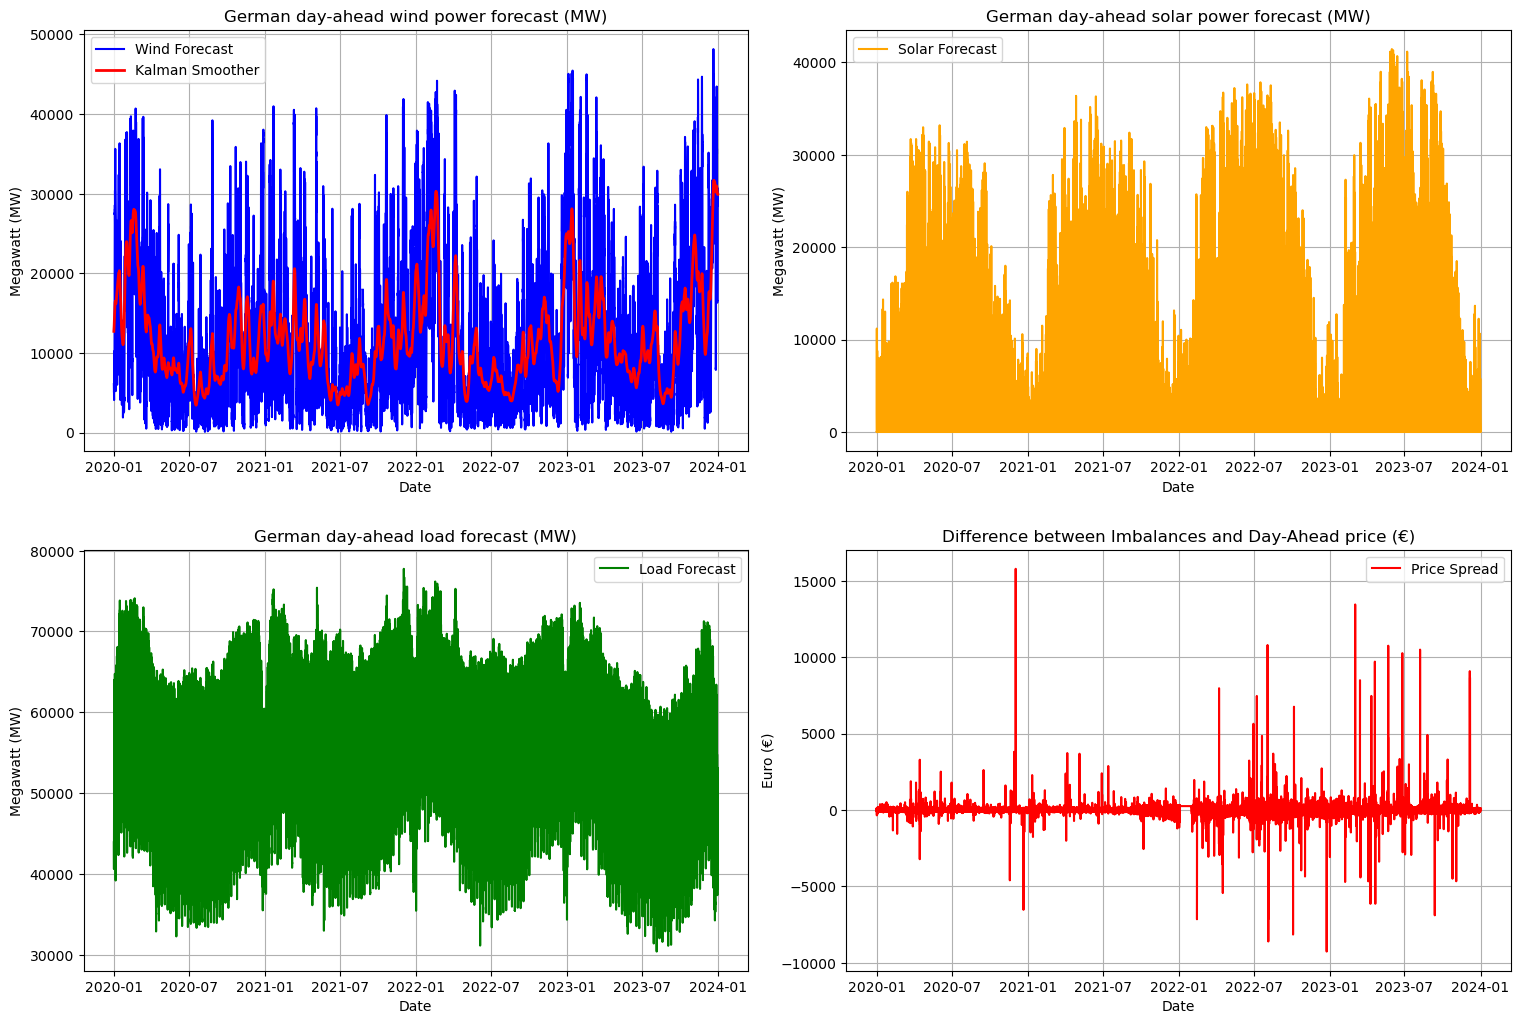

In [7]:
plot_all(df)

- **Wind Power Forecasts (Top Left):** Wind power forecasts demonstrate some yearly seasonal patterns, with reduced wind activity typically observed during the summer months and increased wind levels during winter. 

- **Solar Power Forecasts (Top Right):** Solar power forecasts exhibit a well-defined yearly seasonality, with the lowest levels occurring consistently between December and February. This pattern aligns with reduced daylight hours during winter, providing a predictable trend that is easier to model compared to wind power.

- **Load Forecasts (Bottom Left):** Load forecasts indicate moderate yearly seasonality, with higher demand generally observed from autumn to winter, driven by increased heating needs. Notably, there is a significant dip in late December, likely attributable to reduced economic activity during the Christmas holidays.

- **Spread Between Imbalance and Day-Ahead Prices (Bottom Right):** The spreadappears to be close to 0 most of the 0 however it reveals sudden spikes with ones more pronounced than others particularly after 2022 compared to earlier periods. 

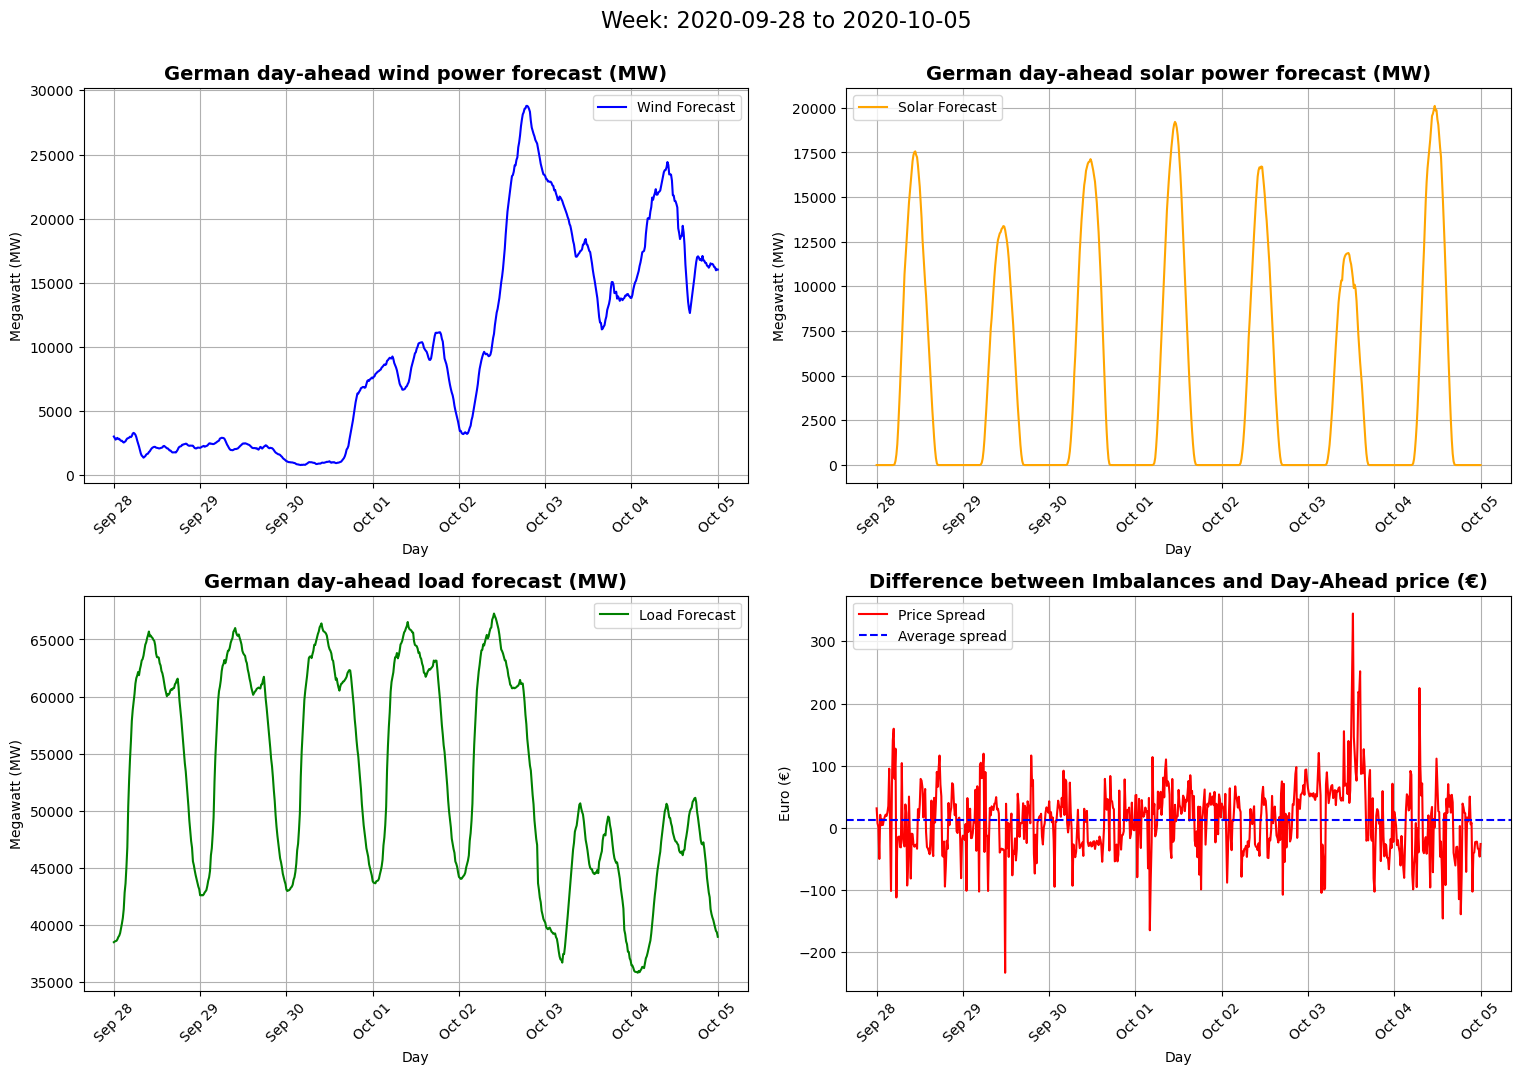

In [8]:
random.seed(42)
plot_week(df)

- Throughout the day, wind power forecasts exhibit smoother patterns, while solar forecasts show a clear peak around noon, following a near-normal distribution. In contrast, load forecasts and the spread are significantly more volatile. The spread appears to mean-revert around zero, which is expected given its nature as a derived metric balancing supply and demand fluctuations.

- There are notable spikes in the price spread on October 3rd and 4th, which are somewhat challenging to interpret. During this period, wind power forecasts remain relatively high compared to earlier days in the week (indicating high supply), while the load forecast reaches its lowest levels of the week (indicating low demand). At the same time, solar power forecasts are at minimal levels, contributing to reduced supply.

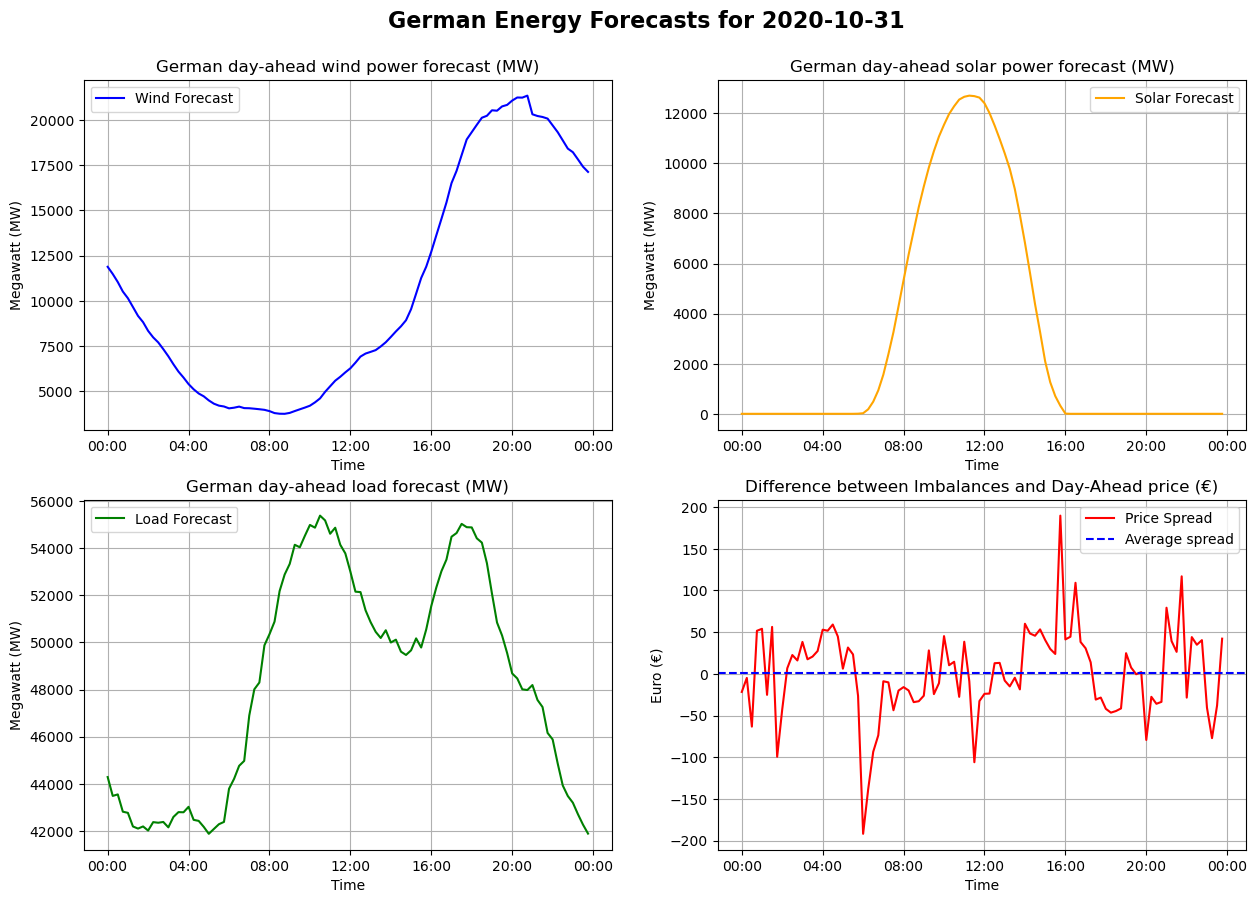

In [9]:
random.seed(42)
plot_day(df)

### **Seasonality Analysis**

With 15-min data, one day is 96 observations (96x15 = 1440 min = 24 hours) and one week is 672 (96x7).

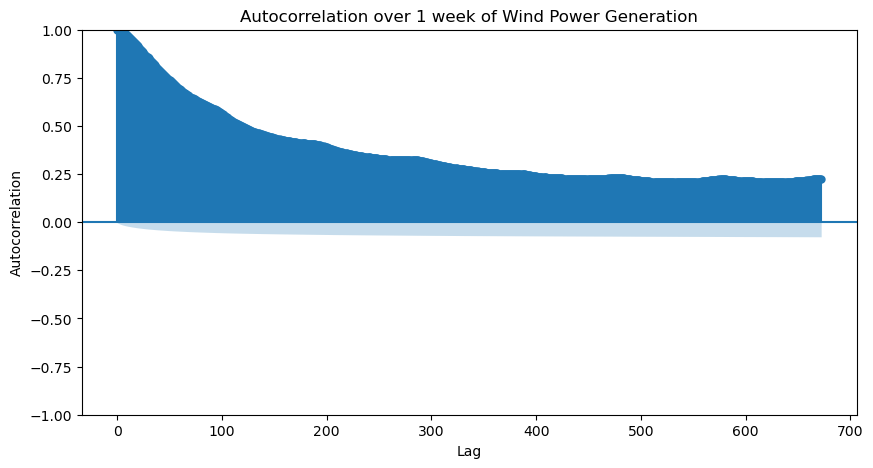

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(df["wind"], lags=672, ax=ax, title="Autocorrelation over 1 week of Wind Power Generation")
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
plt.show()

For wind generation, there is a high level autocorrelation intraday, after one day it is approx **65%** and after one week it is approx **25%**.

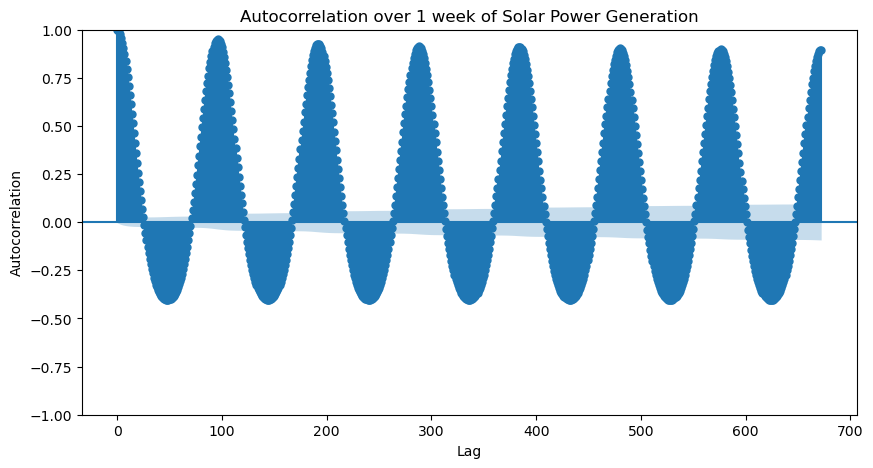

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(df["solar"], lags=672, ax=ax, title="Autocorrelation over 1 week of Solar Power Generation")
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
plt.show()

Compared to wind power, solar displays a strong daily seasonailiy where at every multiple of 96 lags we observe a spike in autocorrelation. This phenomena makes sense sun rises everyday over the course of the week at the same time and with approximately the same intensity.

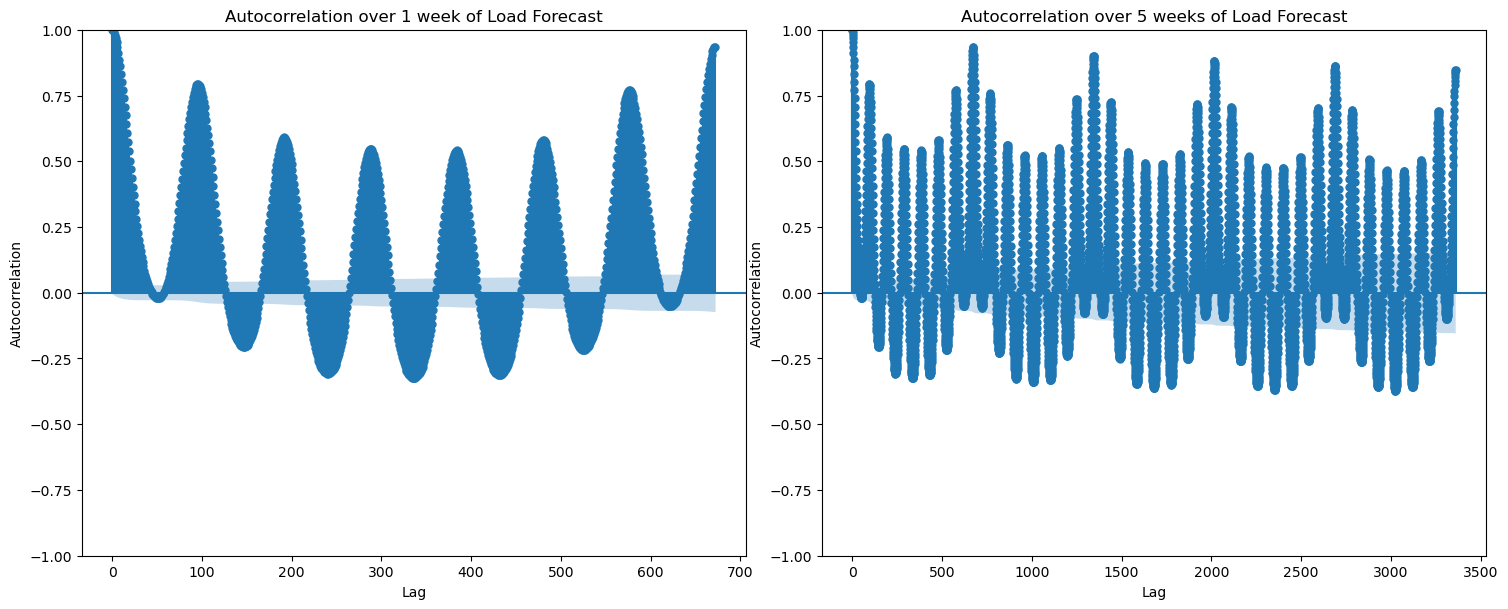

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
plot_acf(df["load"], lags=672, ax=axes[0], title="Autocorrelation over 1 week of Load Forecast")
plot_acf(df["load"], lags=3360, ax=axes[1], title="Autocorrelation over 5 weeks of Load Forecast")
fig.tight_layout()
axes[0].set_xlabel("Lag")
axes[1].set_xlabel("Lag")
axes[0].set_ylabel("Autocorrelation")
axes[1].set_ylabel("Autocorrelation")
plt.xlabel("Lag")
plt.show()

For load, there is both a daily and a weekly seasonality where multiples of 672 display very high autocorrelation levels, indicating a weekly seasonality.

### **Distribution Analysis & Outliers Detection**

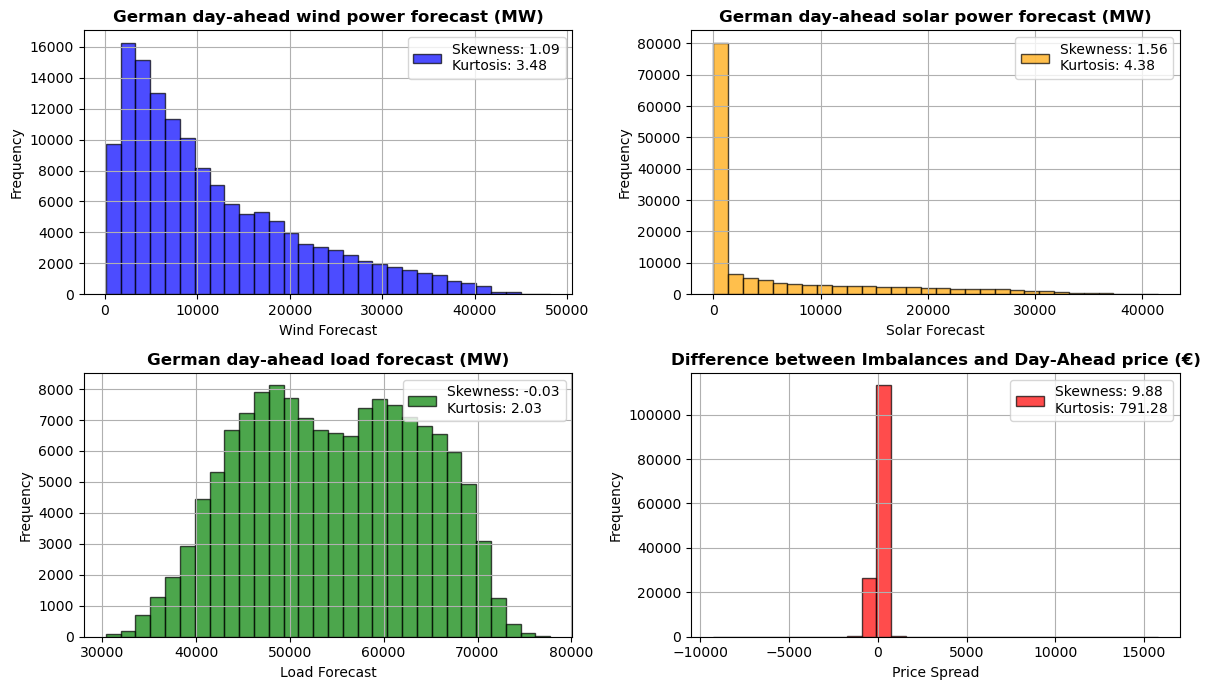

In [13]:
plot_histograms(df[["wind", "solar", "load", "spread"]], figsize=(12, 7))

- **Wind Power Forecast (Top Left)**: The distribution is positively skewed, with most values concentrated at lower power levels and a long tail of occasional high wind forecasts, reflecting the variability of wind generation.

- **Solar Power Forecast (Top Right)**: A heavily right-skewed distribution, with most values near zero, indicates low generation during nighttime or cloudy periods, with peaks corresponding to sunny conditions.

- **Load Forecast (Bottom Left)**: The nearly symmetric, slightly bimodal distribution reflects varying energy consumption patterns, likely driven by differences between weekdays and weekends or daily demand cycles.

- **Spread Between Imbalance and Day-Ahead Prices (Bottom Right)**: The distribution is centered tightly around zero, suggesting close alignment between the two prices, however large outliers cause the dsitribution to have a very poor shape with a high **Skewness** and **Kurtosis**.

*Note: For load forecasts we assume that the distribution is closer to **normal** than **bimodal** because the histogram does not display two distinct peaks that are clearly separated.*

We might consider removing outliers based on the overall distribution, such as filtering wind values above 40,000 or solar values above 35,000, however this approach overlooks a key aspect of time series data: **seasonality**.

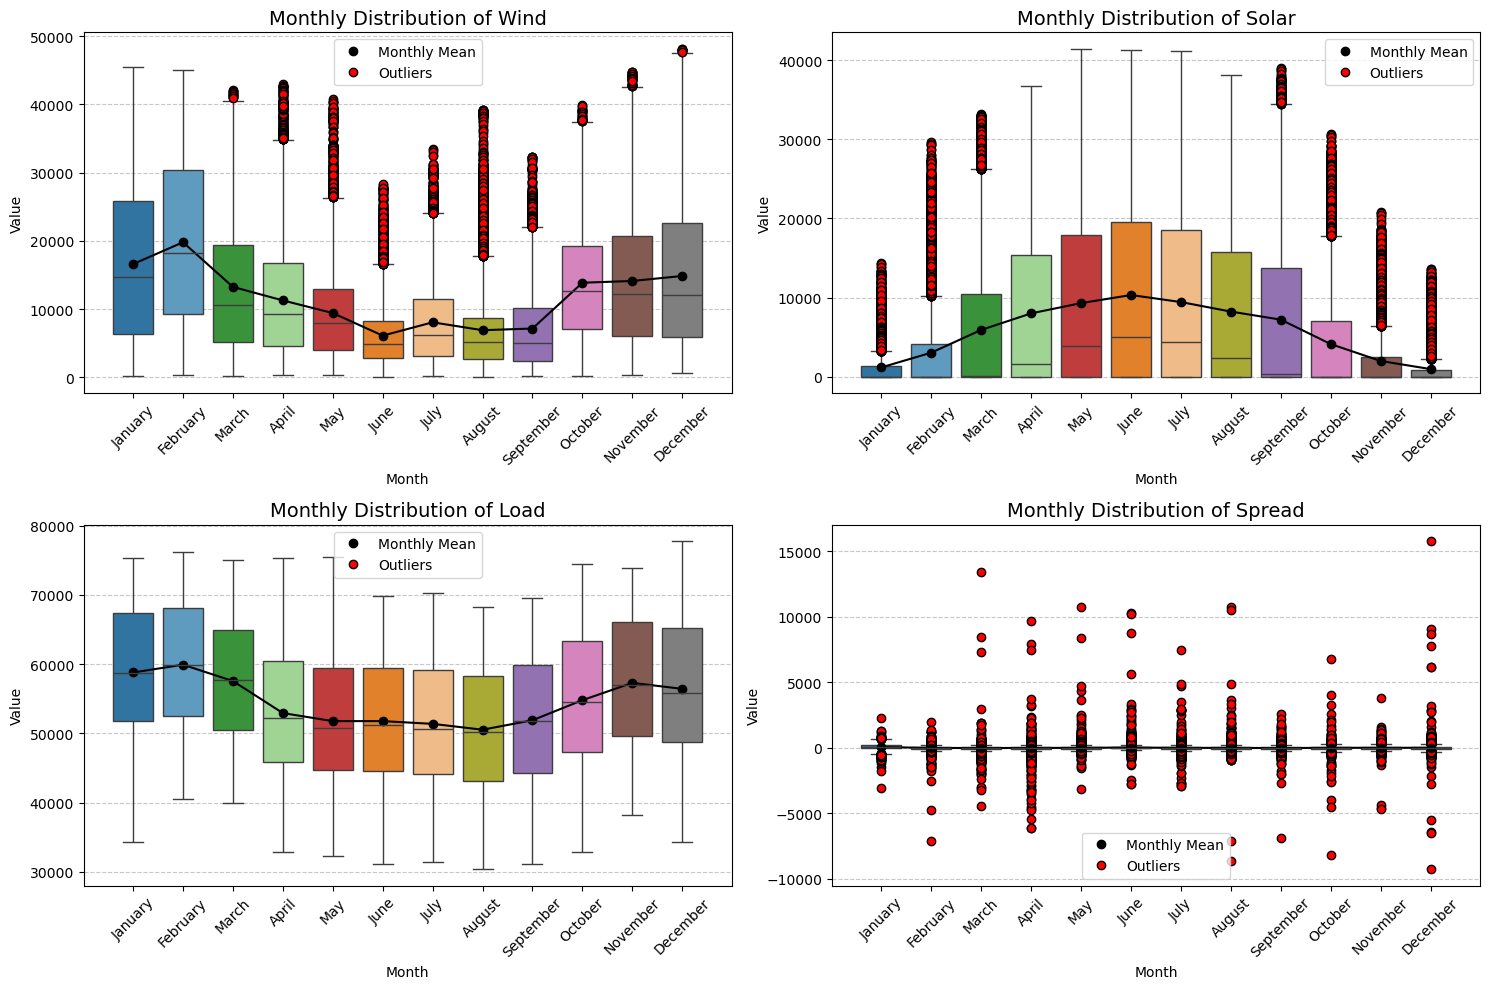

In [14]:
MONTHS = ['January', 'February', 'March', 'April', 'May', 'June', 
                 'July', 'August', 'September', 'October', 'November', 'December']

def plot_monthly_boxplots(df, columns, rows=2, cols=2):
    """
    Plots boxplots for the monthly distribution of selected variables in a grid.

    Args:
        df (pd.DataFrame): The input time-series dataframe with a DatetimeIndex.
        columns (list): List of column names to create boxplots for.
        rows (int): Number of rows in the grid.
        cols (int): Number of columns in the grid.
    """
    data = df.copy()

    data['Month'] = data.index.month_name()

    seasonal_colors = {
        "January": "#1f77b4", "February": "#4f9dcf", "March": "#2ca02c",
        "April": "#98df8a", "May": "#d62728", "June": "#ff7f0e",
        "July": "#ffbb78", "August": "#bcbd22", "September": "#9467bd",
        "October": "#e377c2", "November": "#8c564b", "December": "#7f7f7f"
    }

    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()

    for idx, column in enumerate(columns):
        sns.boxplot(
            data=data, x="Month", hue="Month", y=column, order=MONTHS, ax=axes[idx], legend=False,
            palette=seasonal_colors, flierprops={'markerfacecolor': 'red', 'markeredgecolor': 'black'}
        )
        
        monthly_means = data.groupby("Month")[column].mean().reindex(MONTHS)
        axes[idx].plot(range(len(monthly_means)), monthly_means, marker='o', color='black', label="Monthly Mean")
        axes[idx].set_title(f"Monthly Distribution of {column.capitalize()}", fontsize=14)
        axes[idx].set_xlabel("Month")
        axes[idx].set_ylabel("Value")
        axes[idx].grid(axis="y", linestyle="--", alpha=0.7)
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].legend(
            handles=[
                plt.Line2D([], [], color='black', marker='o', linestyle='', label='Monthly Mean'),
                plt.Line2D([], [], color='red', marker='o', markeredgecolor='black', linestyle='', label='Outliers')
            ]
        )

    for idx in range(len(columns), len(axes)):
        axes[idx].axis("off")

    plt.tight_layout()
    plt.show()

plot_monthly_boxplots(df, columns=["wind", "solar", "load", "spread"])

- **Wind Forecasts:** Wind power displays a clear seasonal pattern, with lower values during summer. The variability and chaotic nature of wind are reflected in the numerous outliers observed, especially in summer months.

- **Solar Forecasts:** Solar forecasts show no significant outliers during spring and summer, but many emerge in fall and winter. The higher mean compared to the median during colder months indicates a skewed distribution for different from 0 solar forecasts, highlighting the need for careful handling of these values.

- **Load Forecasts:** Load data is consistent across months, with no significant outliers. Seasonal trends show slightly higher demand in fall and winter, likely due to heating needs. The close alignment between the mean and median reflects a symmetric distribution, suggesting that no additional outlier handling or transformations are needed.

- **Spread:** The spread mostly remains near 0, as indicated by the narrow box plot, but extreme outliers occur frequently, representing significant deviations between imbalance and day-ahead prices.

 In order to have a finer look at the outliers for wind and solar, we plot the distribution of each month across all the years. Indeed, as observed in the time series from 2020 to 2024, the distribution evolves over the years, as seen with solar power generation forecasts for instance.

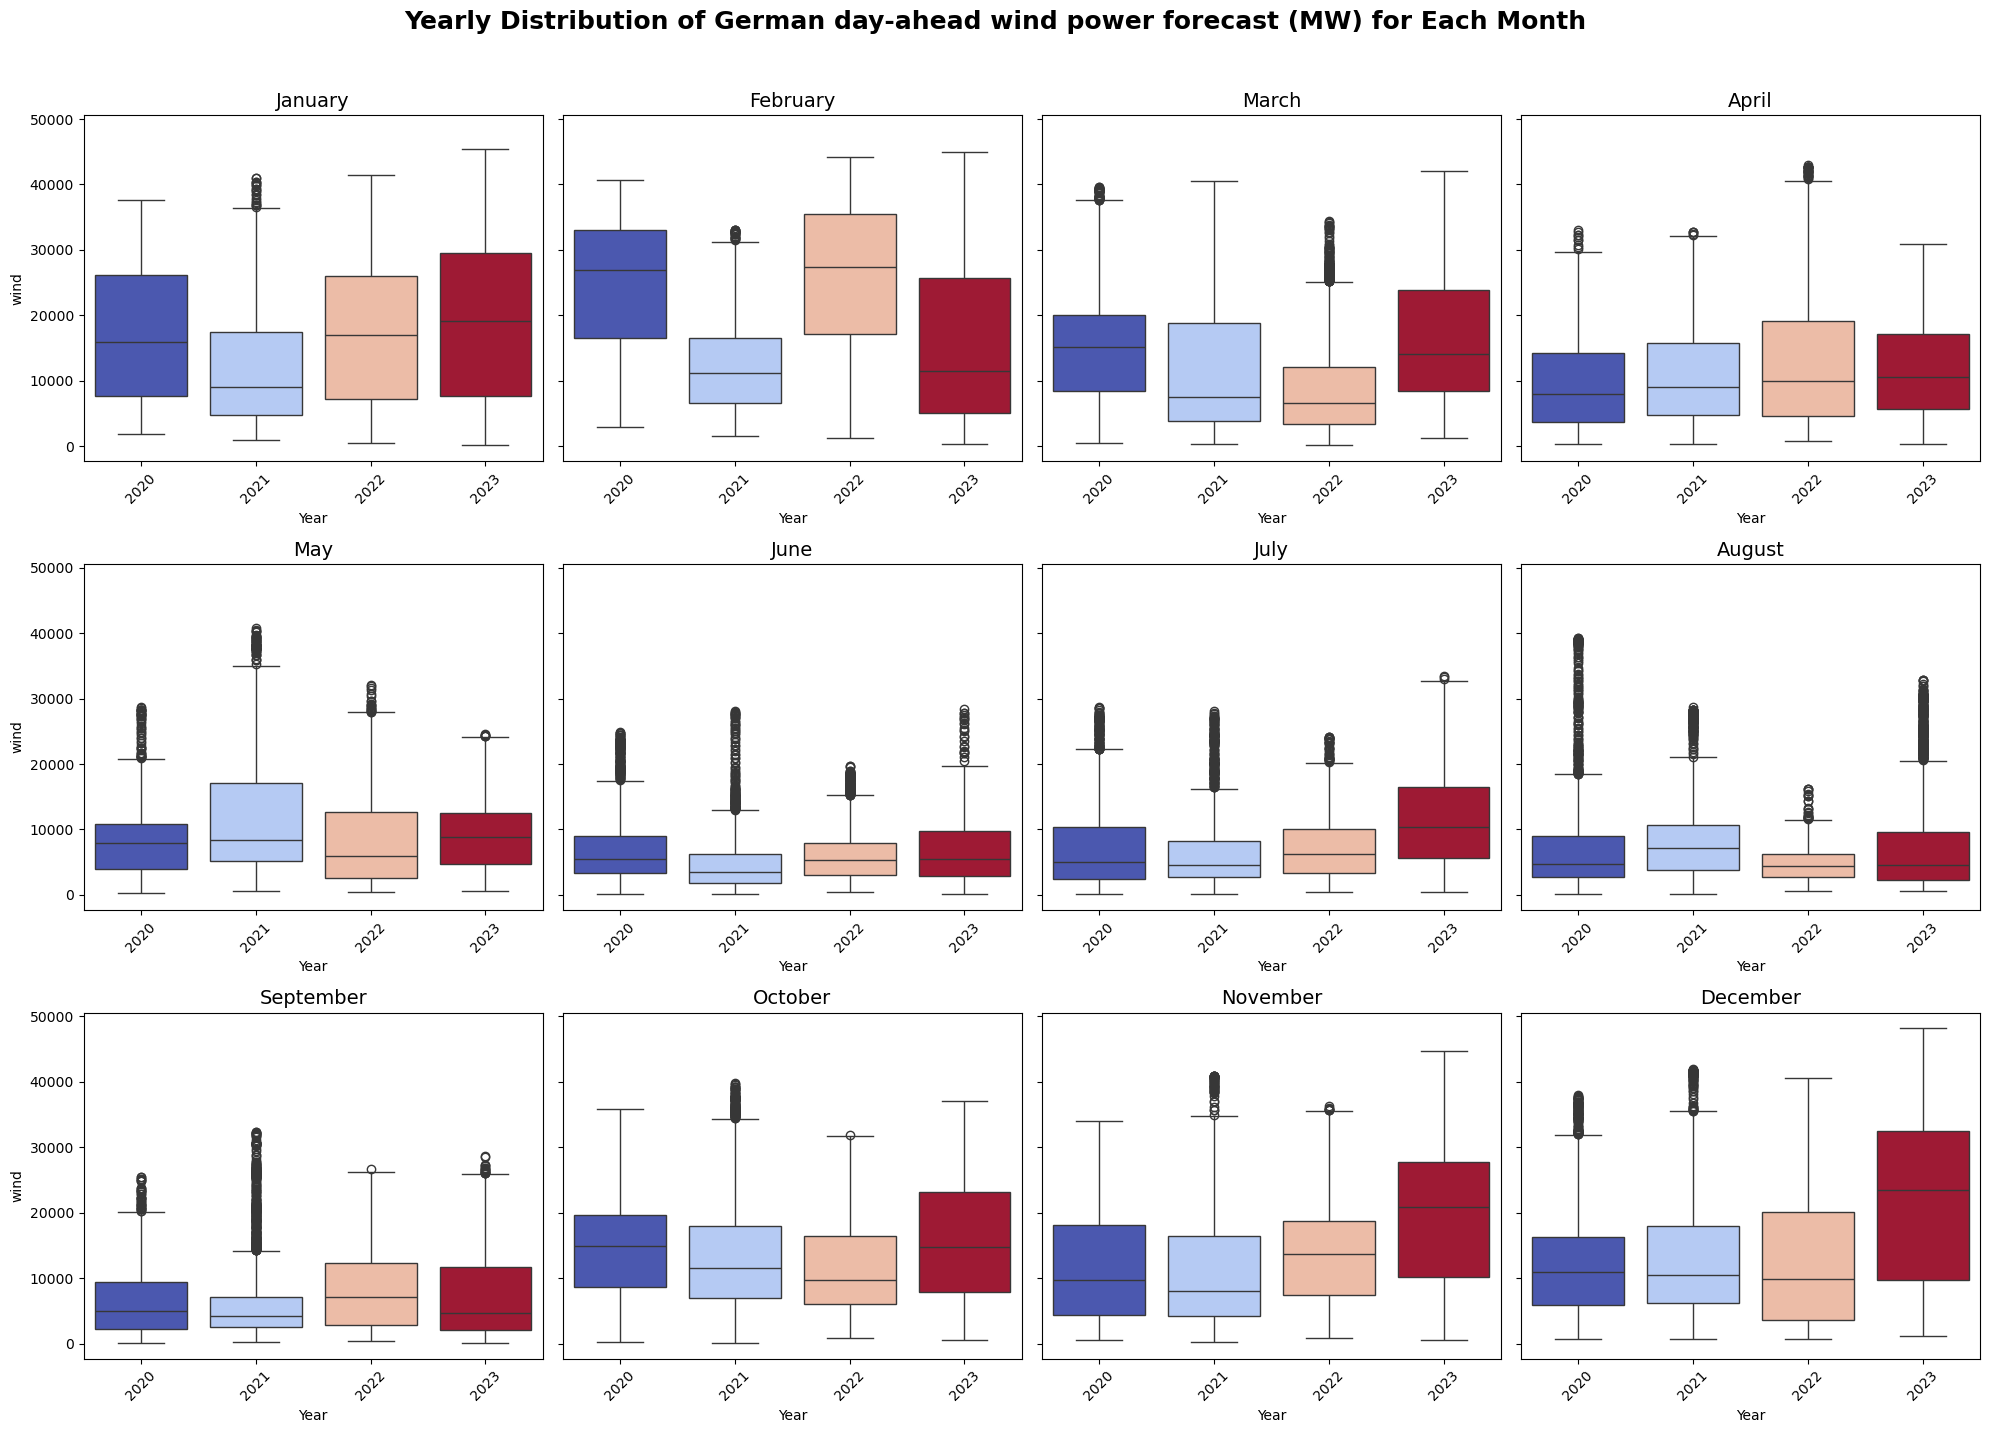

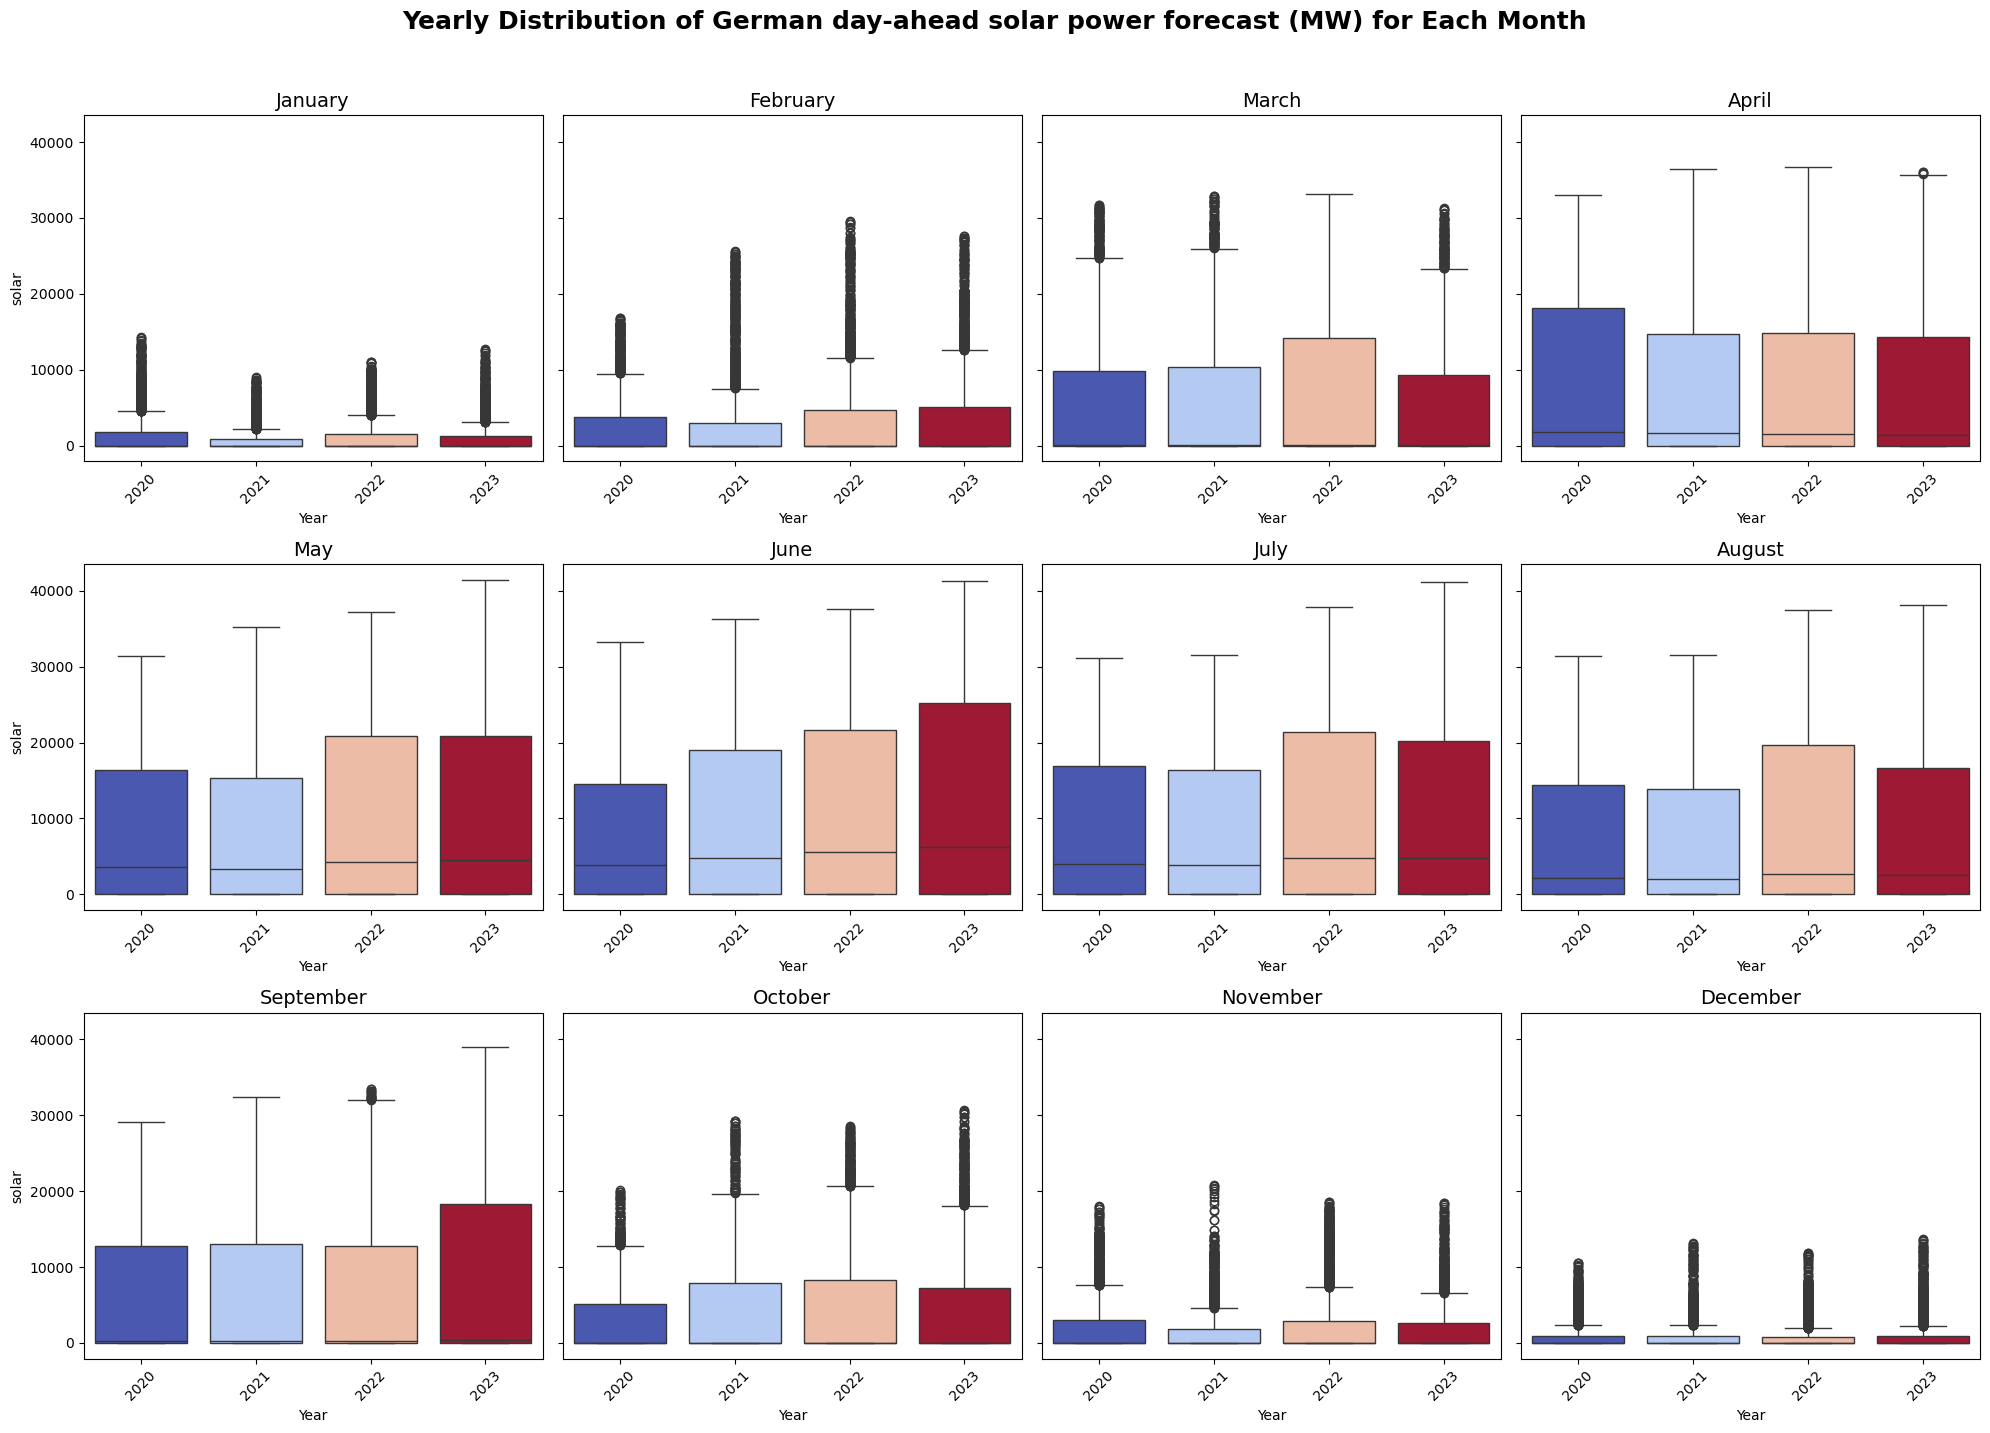

In [15]:
def plot_monthly_yearly_boxplots(df, column):
    """
    Plots a 3x4 grid of yearly boxplots for each month for the specified column.

    Args:
        df (pd.DataFrame): The DataFrame containing the data with a datetime index.
        column (str): The column to visualize with boxplots.
    """
    df['Year'] = df.index.year
    df['Month'] = df.index.month_name()
    
    fig, axes = plt.subplots(3, 4, figsize=(20, 14), sharey=True)
    axes = axes.flatten()

    for idx, month in enumerate(MONTHS):
        month_data = df[df['Month'] == month]
        sns.boxplot(
            x='Year', y=column, data=month_data, ax=axes[idx], palette='coolwarm', 
            hue='Year', legend=False
        )
        axes[idx].set_title(f"{month}", fontsize=14)
        axes[idx].set_xlabel("Year")
        axes[idx].set_ylabel(column)
        axes[idx].tick_params(axis='x', rotation=45)

    for idx in range(len(MONTHS), len(axes)):
        axes[idx].axis('off')

    fig.suptitle(f"Yearly Distribution of {PLOT_CONFIGS[column]["title"]} for Each Month", fontsize=18, y=1.02, fontweight="bold")
    plt.tight_layout()
    plt.show()

plot_monthly_yearly_boxplots(df, 'wind')
plot_monthly_yearly_boxplots(df, 'solar')

Before thinking about an outlier reduction technique, it’s essential to determine whether these outliers represent data errors or natural events. To investigate further, we analyze the two periods with the most outliers: **August 2020** and **September 2021**.

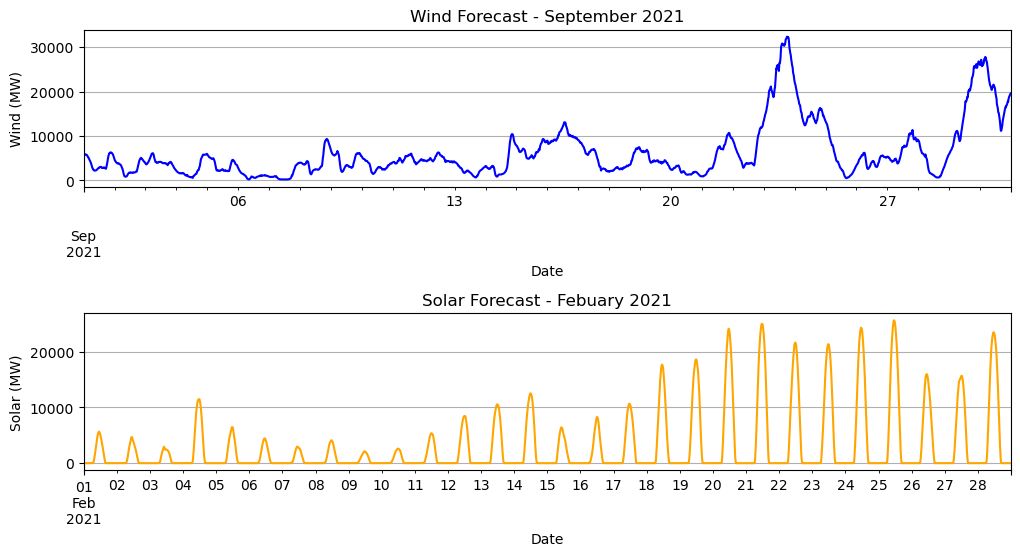

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))
plt.tight_layout(h_pad=7)
df.loc["2021-09", "wind"].plot(ax=ax1, color="blue", title="Wind Forecast - September 2021")
ax1.set_ylabel("Wind (MW)")
ax1.grid(True)
df.loc["2021-02", "solar"].plot(ax=ax2, color="orange", title="Solar Forecast - Febuary 2021")
ax2.set_ylabel("Solar (MW)")
ax2.set_xlabel("Date")
ax2.grid(True)
plt.show()

By visualizing the time series, it becomes evident that many of these “outliers” are natural events, such as peaks due to strong winds, rather than data errors. This underscores the importance of understanding the context of outliers before applying reduction techniques such as outlier removal.

## **Conclusion**

- **Wind:** Positively skewed distribution with outliers caused by natural meteorological phenomena. A transformation is needed to normalize the distribution.

- **Solar:** Highly right-skewed distribution with many zero values due to nighttime. Outliers are also influenced by natural phenomena.

- **Load:** Symmetrical distribution with slight bimodality, though its low intensity can be ignored. No transformation or outlier handling is required.

- **Spread:** Presence of extreme values broadens the distribution, making it appear peaked around zero. Addressing these extreme values is necessary to extract a clearer distribution shape.